### 개와 고양이 데이터 세트의 디렉토리와 파일을 기반으로 메타 정보용 DataFrame 생성 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

def make_catndog_dataframe():
    paths = []
    dataset_gubuns = []
    label_gubuns = []
    # os.walk()를 이용하여 특정 디렉토리 밑에 있는 모든 하위 디렉토리를 모두 조사. 
    # cat-and-dog 하위 디렉토리 밑에 jpg 확장자를 가진 파일이 모두 이미지 파일임
    # cat-and-dog 밑으로 /train/, /test/ 하위 디렉토리 존재(학습, 테스트 용 이미지 파일들을 가짐)

    for dirname, _, filenames in os.walk('/kaggle/input/cat-and-dog'):
        for filename in filenames:
            # 이미지 파일이 아닌 파일도 해당 디렉토리에 있음.
            if '.jpg' in filename:
                # 파일의 절대 경로를 file_path 변수에 할당. 
                file_path = dirname+'/'+ filename
                paths.append(file_path)
                # 파일의 절대 경로에 training_set, test_set가 포함되어 있으면 데이터 세트 구분을 'train'과 'test'로 분류. 
                if '/training_set/' in file_path:
                    dataset_gubuns.append('train')  
                elif '/test_set/' in file_path:
                    dataset_gubuns.append('test')
                else: dataset_gubuns.append('N/A')

                # 파일의 절대 경로에 dogs가 있을 경우 해당 파일은 dog 이미지 파일이고, cats일 경우는 cat 이미지 파일임. 
                if 'dogs' in file_path:
                    label_gubuns.append('DOG')
                elif 'cats' in file_path:
                    label_gubuns.append('CAT')
                else: label_gubuns.append('N/A')
    
    data_df = pd.DataFrame({'path':paths, 'dataset':dataset_gubuns, 'label':label_gubuns})
    return data_df

In [2]:
pd.set_option('display.max_colwidth', 200)
data_df = make_catndog_dataframe()
print('data_df shape:', data_df.shape)
data_df.head()

data_df shape: (10028, 3)


,path,dataset,label
0,/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg,test,DOG
1,/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg,test,DOG
2,/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg,test,DOG
3,/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg,test,DOG
4,/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg,test,DOG


### Keras Sequence를 상속받은 Dataset 객체를 생성

In [3]:
list_a = [1, 2, 3, 4, 5]
print(len(list_a)) # __len__(self) 호출
print(list_a[0]) # __getitem__(self, index)

5
1


In [4]:
from tensorflow.keras.utils import Sequence
import sklearn 
import cv2

# 배치 크기와 이미지 크기를 전역 변수로 선언 
BATCH_SIZE = 64
IMAGE_SIZE = 224

# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class CnD_Dataset(Sequence):
    # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당.
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle = shuffle
        # train data의 경우 첫번째 에포크에만 데이터를 섞는다.
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
            
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다.
        return int(np.ceil(len(self.labels)/self.batch_size))
        
    def __getitem__(self, index): # index는 steps의 index이다.
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size] 
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음.
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
        
            image_batch[image_index] = image
       
        return image_batch, label_batch
             
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Sequence 기반 Dataset을 생성하고 호출하기
* albumentations를 이용하여 BATCH 크기 만큼 데이터를 Augmentation 한 뒤 데이터를 반환 할 수 있는 Sequence 기반 Dataset을 생성하고 호출하기 

In [5]:
data_df.head()

,path,dataset,label
0,/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg,test,DOG
1,/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg,test,DOG
2,/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg,test,DOG
3,/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg,test,DOG
4,/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg,test,DOG


In [6]:
import albumentations as A

# 전체 데이터 세트에서 학습과 테스트용 메타 정보 DataFrame 생성. 
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# image file의 위치가 있는 데이터와 label값을 numpy array로 변환. 
train_image_filenames = train_df['path'].values
train_image_labels = train_df['label'].values

cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

# Sequence를 상속받은 CnD_Dataset을 image 파일 위치, label값, albumentations 변환 객체를 입력하여 생성. 
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

In [7]:
train_image_filenames.shape

(8005,)

In [8]:
#next(iter(cnd_ds))
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

(64, 224, 224, 3) (64,)
[[[222. 218. 207.]
  [223. 219. 208.]
  [222. 218. 207.]
  ...
  [237. 230. 222.]
  [237. 230. 222.]
  [237. 230. 222.]]

 [[222. 218. 207.]
  [225. 221. 210.]
  [224. 220. 209.]
  ...
  [237. 230. 222.]
  [237. 230. 222.]
  [237. 230. 222.]]

 [[223. 219. 208.]
  [227. 223. 212.]
  [229. 225. 214.]
  ...
  [238. 231. 223.]
  [238. 231. 223.]
  [238. 231. 223.]]

 ...

 [[184. 180. 155.]
  [183. 179. 154.]
  [182. 178. 154.]
  ...
  [183. 174. 156.]
  [187. 178. 161.]
  [189. 180. 163.]]

 [[183. 179. 154.]
  [182. 178. 153.]
  [181. 177. 152.]
  ...
  [182. 173. 156.]
  [186. 177. 160.]
  [188. 180. 163.]]

 [[184. 180. 155.]
  [182. 178. 153.]
  [182. 178. 153.]
  ...
  [182. 174. 154.]
  [186. 178. 159.]
  [188. 180. 161.]]]


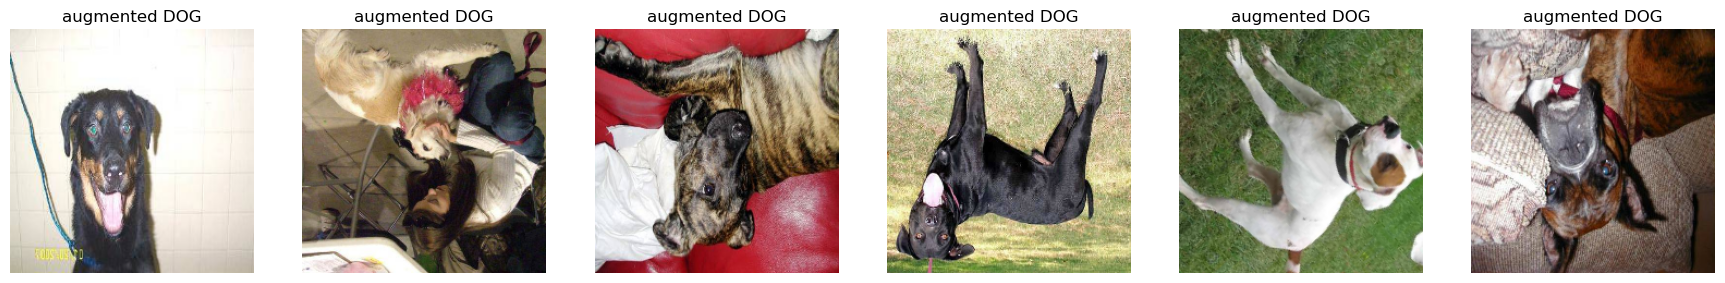

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show_grid_images(images_batch, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        # image_batch는 float형이므로 int형으로 변경하여 이미지 시각화
        axs[i].imshow(np.array(images_batch[i], dtype='int32'))
        axs[i].axis('off')
        axs[i].set_title(title[i]) 
        
show_grid_images(images_batch, ncols=6, title='augmented ' + labels_batch)

### 원본 이미지 픽셀값의 scaling을 감안하여 다시 CnD_Dataset 재 작성. 

In [10]:
# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            
            # 이미지 값을 0 ~ 1 로 스케일링. 
            image = image/255.0
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [11]:
# Sequence를 상속받은 CnD_Dataset을 image 파일 위치, label값, albumentations 변환 객체를 입력하여 생성. 
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:2])

(64, 224, 224, 3) (64,)
[[[[0.87058824 0.85490197 0.8117647 ]
   [0.8745098  0.85882354 0.8156863 ]
   [0.87058824 0.85490197 0.8117647 ]
   ...
   [0.92941177 0.9019608  0.87058824]
   [0.92941177 0.9019608  0.87058824]
   [0.92941177 0.9019608  0.87058824]]

  [[0.87058824 0.85490197 0.8117647 ]
   [0.88235295 0.8666667  0.8235294 ]
   [0.8784314  0.8627451  0.81960785]
   ...
   [0.92941177 0.9019608  0.87058824]
   [0.92941177 0.9019608  0.87058824]
   [0.92941177 0.9019608  0.87058824]]

  [[0.8745098  0.85882354 0.8156863 ]
   [0.8901961  0.8745098  0.83137256]
   [0.8980392  0.88235295 0.8392157 ]
   ...
   [0.93333334 0.90588236 0.8745098 ]
   [0.93333334 0.90588236 0.8745098 ]
   [0.93333334 0.90588236 0.8745098 ]]

  ...

  [[0.72156864 0.7058824  0.60784316]
   [0.7176471  0.7019608  0.6039216 ]
   [0.7137255  0.69803923 0.6039216 ]
   ...
   [0.7176471  0.68235296 0.6117647 ]
   [0.73333335 0.69803923 0.6313726 ]
   [0.7411765  0.7058824  0.6392157 ]]

  [[0.7176471  0.7019

### Pretrained 모델에서 사용하는 보다 범용적인 Preprocessing을 적용할 수 있도록 재작성. 
* pre_func 인자를 추가하여 pretrained 모델의 preprocess_input 함수를 인자로 입력할 수 있도록 수정. 

In [12]:
# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. 
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None): # pre_func는 preprocessing 함수이다.
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.labels)/self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index*self.batch_size:(index+1)*self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3), dtype='float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
            
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

In [13]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor, shuffle=False, pre_func=xcp_preprocess_input)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0:2])

(64, 224, 224, 3) (64,)
[[[[-0.3960784  -0.372549   -0.31764704]
   [-0.36470586 -0.34117645 -0.2235294 ]
   [-0.20784312 -0.17647058 -0.03529412]
   ...
   [ 0.99215686  0.99215686  0.99215686]
   [ 0.99215686  0.99215686  0.99215686]
   [ 0.99215686  0.99215686  0.99215686]]

  [[-0.38039213 -0.35686272 -0.26274508]
   [-0.31764704 -0.2862745  -0.1607843 ]
   [-0.09019607 -0.05098039  0.082353  ]
   ...
   [ 0.99215686  0.99215686  0.99215686]
   [ 0.99215686  0.99215686  0.99215686]
   [ 0.99215686  0.99215686  0.99215686]]

  [[-0.38823527 -0.35686272 -0.23921567]
   [-0.2235294  -0.17647058 -0.05098039]
   [-0.27843136 -0.23921567 -0.1372549 ]
   ...
   [ 0.99215686  0.99215686  0.99215686]
   [ 0.99215686  0.99215686  0.99215686]
   [ 0.99215686  0.99215686  0.99215686]]

  ...

  [[-0.654902   -0.6        -0.56078434]
   [-0.70980394 -0.67058825 -0.62352943]
   [-0.56078434 -0.52156866 -0.4823529 ]
   ...
   [ 0.9764706   0.92156863  0.85882354]
   [ 0.9764706   0.92156863  0.85

### 별도의 preprocessing 함수나 Albumentations의 Normalize 적용 가능 

In [14]:
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])

def zero_one_scaler(image):
    return image/255.0

cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor, shuffle=False, pre_func=zero_one_scaler)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]

images_batch[0:2]

array([[[[0.92941177, 0.9019608 , 0.87058824],
         [0.92941177, 0.9019608 , 0.87058824],
         [0.92941177, 0.9019608 , 0.87058824],
         ...,
         [0.87058824, 0.85490197, 0.8117647 ],
         [0.8745098 , 0.85882354, 0.8156863 ],
         [0.87058824, 0.85490197, 0.8117647 ]],

        [[0.92941177, 0.9019608 , 0.87058824],
         [0.92941177, 0.9019608 , 0.87058824],
         [0.92941177, 0.9019608 , 0.87058824],
         ...,
         [0.8784314 , 0.8627451 , 0.81960785],
         [0.88235295, 0.8666667 , 0.8235294 ],
         [0.87058824, 0.85490197, 0.8117647 ]],

        [[0.93333334, 0.90588236, 0.8745098 ],
         [0.93333334, 0.90588236, 0.8745098 ],
         [0.93333334, 0.90588236, 0.8745098 ],
         ...,
         [0.8980392 , 0.88235295, 0.8392157 ],
         [0.8901961 , 0.8745098 , 0.83137256],
         [0.8745098 , 0.85882354, 0.8156863 ]],

        ...,

        [[0.7411765 , 0.7058824 , 0.6392157 ],
         [0.73333335, 0.69803923, 0.6313726 ]

In [15]:
cnd_augmentor_normalized = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, 
                         augmentor=cnd_augmentor_normalized, shuffle=False, pre_func=None)
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
images_batch[0]

array([[[2.1804092, 2.2885153, 2.4308496],
        [2.1804092, 2.2710083, 2.4308496],
        [2.1804092, 2.2710083, 2.4308496],
        ...,
        [2.2489083, 2.3760502, 2.4308496],
        [2.2489083, 2.3760502, 2.4308496],
        [2.2489083, 2.3760502, 2.4308496]],

       [[2.1804092, 2.2885153, 2.4308496],
        [2.1804092, 2.2710083, 2.4308496],
        [2.1804092, 2.2710083, 2.4308496],
        ...,
        [2.2489083, 2.3935573, 2.448279 ],
        [2.2489083, 2.3760502, 2.4308496],
        [2.2489083, 2.3760502, 2.4308496]],

       [[2.1804092, 2.2710083, 2.4308496],
        [2.1804092, 2.2710083, 2.4308496],
        [2.1804092, 2.2710083, 2.4308496],
        ...,
        [2.2489083, 2.4110644, 2.465708 ],
        [2.2489083, 2.3935573, 2.448279 ],
        [2.2489083, 2.3760502, 2.4308496]],

       ...,

       [[1.358421 , 1.3606442, 1.3153813],
        [1.358421 , 1.3606442, 1.3153813],
        [1.3755457, 1.3781512, 1.3328104],
        ...,
        [1.700916 , 1.7983

### 학습, 검증 데이터 분할 및 레이블 인코딩 적용 

In [16]:
pd.factorize(train_df['label'])[0].shape # One Hot Encoding인데 Cat, Dog 형태의 2차원 배열이 되지 않는다.

(8005,)

In [17]:
pd.get_dummies(train_df['label']).values # One Hot Encoding 적용

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [18]:
labels_ohe = pd.get_dummies(train_df['label']).values
print(labels_ohe[:5])

labels_enc = pd.factorize(train_df['label'])[0]
print(labels_enc[:5])

print(labels_ohe.shape, labels_enc.shape)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]
[0 0 0 0 0]
(8005, 2) (8005,)


In [19]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터용 Dataframe 생성. 
train_df = data_df[data_df['dataset']=='train']
test_df = data_df[data_df['dataset']=='test']

# 학습 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
train_path = train_df['path'].values
train_label = pd.factorize(train_df['label'])[0]


tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=2021)
print('학습용 path shape:', tr_path.shape, '검증용 path shape:', val_path.shape, 
      '학습용 label shape:', tr_label.shape, '검증용 label shape:', val_label.shape)

학습용 path shape: (6804,) 검증용 path shape: (1201,) 학습용 label shape: (6804,) 검증용 label shape: (1201,)


In [20]:
cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.3),
    #A.VerticalFlip(p=0.5),
    #A.ShiftScaleRotate(p=0.5)
])

In [21]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, 
                      shuffle=True, pre_func=xcp_preprocess_input)
val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

tr_image_batch = next(iter(tr_ds))[0]
val_image_batch = next(iter(val_ds))[0]
print(tr_image_batch.shape, val_image_batch.shape)

print(tr_image_batch[:1])
print(val_image_batch[:1])


(64, 224, 224, 3) (64, 224, 224, 3)
[[[[ 0.05882359 -0.05098039 -0.32549018]
   [ 0.05882359 -0.05098039 -0.32549018]
   [ 0.05882359 -0.05098039 -0.32549018]
   ...
   [-0.15294117 -0.21568626 -0.4980392 ]
   [-0.25490195 -0.34117645 -0.60784316]
   [-0.27058822 -0.38823527 -0.64705884]]

  [[ 0.05882359 -0.05098039 -0.32549018]
   [ 0.05882359 -0.05098039 -0.32549018]
   [ 0.05882359 -0.05098039 -0.32549018]
   ...
   [-0.10588235 -0.16862744 -0.45098037]
   [-0.27058822 -0.35686272 -0.6313726 ]
   [-0.24705881 -0.372549   -0.62352943]]

  [[ 0.06666672 -0.04313725 -0.31764704]
   [ 0.06666672 -0.04313725 -0.31764704]
   [ 0.06666672 -0.04313725 -0.31764704]
   ...
   [-0.11372548 -0.17647058 -0.4588235 ]
   [-0.2862745  -0.372549   -0.6392157 ]
   [-0.26274508 -0.38039213 -0.6392157 ]]

  ...

  [[-0.03529412 -0.62352943 -0.8352941 ]
   [ 0.0196079  -0.56078434 -0.85882354]
   [ 0.05882359 -0.5137255  -0.8666667 ]
   ...
   [-0.05882353 -0.56078434 -0.85882354]
   [-0.0745098  -0.57

In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception, MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    # 최종 output 출력을 softmax에서 sigmoid로 변환. 
    output = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [23]:
import tensorflow as tf

tf.keras.backend.clear_session()

model = create_model(model_name='xception')
# 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환 
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

83683744/83683744 [==============================] - 0s 0us/step


In [24]:
len(val_ds) # __len__

19

In [25]:
N_EPOCHS = 15
history = model.fit(tr_ds, epochs=N_EPOCHS, 
                    steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)), 
                    validation_data=val_ds, 
                    validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                   callbacks=([rlr_cb, ely_cb]), verbose=1)

Epoch 1/15
107/107 [==============================] - 132s 831ms/step - loss: 0.1278 - accuracy: 0.9546 - val_loss: 0.3522 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 2/15
107/107 [==============================] - 62s 574ms/step - loss: 0.0566 - accuracy: 0.9777 - val_loss: 0.2009 - val_accuracy: 0.9509 - lr: 0.0010
Epoch 3/15
107/107 [==============================] - 62s 578ms/step - loss: 0.0492 - accuracy: 0.9835 - val_loss: 0.1711 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/15
107/107 [==============================] - 62s 574ms/step - loss: 0.0355 - accuracy: 0.9878 - val_loss: 0.1822 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 5/15
107/107 [==============================] - 62s 572ms/step - loss: 0.0288 - accuracy: 0.9909 - val_loss: 0.1702 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 6/15
107/107 [==============================] - 62s 574ms/step - loss: 0.0408 - accuracy: 0.9866 - val_loss: 0.5176 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 7/15
107/107 [==============================]

### 테스트용 Dataset 생성 후 성능 검증 

In [26]:
test_df = data_df[data_df['dataset']=='test']

# 테스트 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
test_path = test_df['path'].values
test_label = pd.factorize(test_df['label'])[0]

test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

model.evaluate(test_ds)

32/32 [==============================] - 20s 636ms/step - loss: 0.0569 - accuracy: 0.9812


[0.05690934881567955, 0.9812160134315491]

### 다른 Pretrained 모델을 이용하여 성능 테스트 

In [27]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

def get_train_valid_test(data_df):
    # 학습 데이터와 테스트 데이터용 Dataframe 생성. 
    train_df = data_df[data_df['dataset']=='train']
    test_df = data_df[data_df['dataset']=='test']

    # 학습 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
    train_path = train_df['path'].values
    train_label = pd.factorize(train_df['label'])[0]
    
    test_path = test_df['path'].values
    test_label = pd.factorize(test_df['label'])[0]

    tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=2021)
    
    return tr_path, tr_label, val_path, val_label, test_path, test_label
    
    
def do_train_evaluation(data_df, model_name, augmentor, preprocessing_func):
    # 학습/검증/테스트용 이미지 파일 절대경로와 Label encoding 된 데이터 세트 반환
    tr_path, tr_label, val_path, val_label, test_path, test_label = get_train_valid_test(data_df)
    
    # 학습과 검증용 Sequence Dataset 생성. 
    tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=augmentor, 
                          shuffle=True, pre_func=preprocessing_func)
    val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                           shuffle=False, pre_func=preprocessing_func)
    
    # 입력된 model_name에 따라 모델 생성. 
    model = create_model(model_name=model_name)
    # 최종 output 출력을 softmax에서 sigmoid로 변환되었으므로 binary_crossentropy로 변환 
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # 2번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
    # 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=7, mode='min', verbose=1)

    N_EPOCHS = 15
    # 학습 수행. 
    history = model.fit(tr_ds, epochs=N_EPOCHS, steps_per_epoch=int(np.ceil(tr_path.shape[0]/BATCH_SIZE)), 
                       validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/BATCH_SIZE)),
                       callbacks=([rlr_cb, ely_cb]), verbose=1)
    
    # 테스트용 Sequence Dataset 생성후 evaluation 수행. 
    test_ds = CnD_Dataset(test_path, test_label, batch_size=BATCH_SIZE, augmentor=None, 
                           shuffle=False, pre_func=preprocessing_func)

    evaluation_result = model.evaluate(test_ds)
    print(evaluation_result)
    
    return history, evaluation_result

In [28]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

tf.keras.backend.clear_session()

cnd_augmentor1 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(p=0.2),
    A.RandomBrightnessContrast(p=0.2)
])

history1, result1 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor1, mobile_preprocess_input)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/15
107/107 [==============================] - 81s 458ms/step - loss: 0.1555 - accuracy: 0.9419 - val_loss: 3.8949 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 2/15
107/107 [==============================] - 50s 464ms/step - loss: 0.0885 - accuracy: 0.9669 - val_loss: 1.0324 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 3/15
107/107 [==============================] - 48s 451ms/step - loss: 0.0727 - accuracy: 0.9727 - val_loss: 0.9959 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 4/15
107/107 [==============================] - 43s 403ms/step - loss: 0.0551 - accuracy: 0.9787 - val_loss: 3.5087 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 5/15
107/107 [==============================] - 47s 435ms/step - loss: 0.0681 - accuracy: 0.9752 - val_loss: 4.1172 - val_accuracy: 0.6595 - lr: 0.0010
Epoch 6/15
107/107 [==============================] - ETA: 0s - loss: 0.0449 - accuracy: 0.9840
Epoch 6: ReduceLROnPlateau reducing learning rate t

In [29]:
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_preprocess_input

tf.keras.backend.clear_session()

cnd_augmentor2 = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ColorJitter(p=0.2),
    A.CLAHE(p=0.2),
    A.Cutout(p=0.2)
])

history2, result2 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor2, mobile_preprocess_input)

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Epoch 1/15
107/107 [==============================] - 79s 473ms/step - loss: 0.1541 - accuracy: 0.9369 - val_loss: 5.6226 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 2/15
107/107 [==============================] - 51s 480ms/step - loss: 0.0891 - accuracy: 0.9674 - val_loss: 2.9432 - val_accuracy: 0.7094 - lr: 0.0010
Epoch 3/15
107/107 [==============================] - 51s 477ms/step - loss: 0.0718 - accuracy: 0.9737 - val_loss: 2.7662 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 4/15
107/107 [==============================] - 51s 480ms/step - loss: 0.0543 - accuracy: 0.9787 - val_loss: 1.9714 - val_accuracy: 0.7827 - lr: 0.0010
Epoch 5/15
107/107 [==============================] - 49s 459ms/step - loss: 0.0516 - accuracy: 0.9812 - val_loss: 4.4624 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 6/15
107/107 [==============================] - 49s 462ms/step - loss: 0.0621 - accuracy: 0.9765 - val_loss: 0.9177 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 7/15
107/107 [==============================] 

In [30]:
tf.keras.backend.clear_session()

cnd_augmentor3 = A.Compose([
    A.HorizontalFlip(p=0.3)
])

history3, result3 = do_train_evaluation(data_df, 'mobilenet', cnd_augmentor3, mobile_preprocess_input)

Epoch 1/15
107/107 [==============================] - 71s 401ms/step - loss: 0.1475 - accuracy: 0.9436 - val_loss: 0.8635 - val_accuracy: 0.8793 - lr: 0.0010
Epoch 2/15
107/107 [==============================] - 45s 417ms/step - loss: 0.0751 - accuracy: 0.9700 - val_loss: 1.5896 - val_accuracy: 0.8418 - lr: 0.0010
Epoch 3/15
107/107 [==============================] - 47s 442ms/step - loss: 0.0630 - accuracy: 0.9763 - val_loss: 2.4828 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 4/15
107/107 [==============================] - 44s 408ms/step - loss: 0.0573 - accuracy: 0.9806 - val_loss: 0.8268 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 5/15
107/107 [==============================] - 43s 403ms/step - loss: 0.0563 - accuracy: 0.9805 - val_loss: 1.1517 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 6/15
107/107 [==============================] - 44s 408ms/step - loss: 0.0447 - accuracy: 0.9837 - val_loss: 2.6914 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 7/15
107/107 [==============================] 